In [1]:
import numpy as np
from statsmodels.tsa.stattools import ccovf
from statsmodels.tsa.stattools import acovf
from statsmodels.tsa.stattools import ccf
from scipy.linalg import solve_continuous_lyapunov
from numba import jit
from scipy import signal
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib import colors
from ipywidgets import interactive 
from ipywidgets import fixed
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, Latex

In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
def threshlin(I, k):
    return k*np.maximum(I, 0)

def d_threshlin(I, k):
    return k*(np.maximum(I, 0) / np.abs(I))

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

def theory_cov(N, k, s, r_ss, W, c_ne, c_ni, tau_n, tau):
    sgn = np.block([
        [np.ones((3*N,N)), np.ones((3*N,N)), -np.ones((3*N,N))]
    ])
    
    c_n = np.diagflat(np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ]))
    
    L = np.diagflat(d_threshlin(s + (sgn*W)@r_ss, k))
    LW = L@(sgn*W)
    Eye = np.eye(3*N)
    
    M = (1/tau)*(-Eye + LW)
    Minv = np.linalg.inv(M)
    
    D = c_n@L
    D = (1/tau)*np.sqrt(2*tau_n)*D
    
    Sigma = Minv @ D @ ((Minv@D).T)
    
    return Sigma

def model(t0, T, dt, N, tau_E, tau_I, c_ne, c_ni, J_E1E1, J_E2E2, J_E1E2, J_E2E1, J_II, J_EI, J_IE, k, s, a, b):
    r1 = np.zeros((N,1))
    r2 = np.zeros((N,1))
    rI = np.zeros((N,1))
    
    # matrices to store firing rates as row and time as column
    R_ss = np.zeros((3*N, 1))
    R_n = np.zeros((3*N, 1))
    
    xs = np.linspace(0, N-1, N)

    W_E1E1 = J_E1E1
    W_E2E2 = J_E2E2
    W_IE1 = W_IE2 = J_IE
    W_E1I = W_E2I = J_EI
    W_II = J_II
    
    W_E1E2 = b*J_E1E2
    W_E2E1 = a*J_E2E1
    
    W = np.block([
        [W_E1E1, W_E1E2, W_E1I],
        [W_E2E1, W_E2E2, W_E2I],
        [W_IE1, W_IE2, W_II]
    ])
    
    sgn = np.block([
        [np.ones((3*N,N)), np.ones((3*N,N)), -np.ones((3*N,N))]
    ])
    
    # s = np.block([
    #     [s],
    #     [s],
    #     [s]
    # ])
    
    r_n = np.zeros((3*N,1))
    r_ss = np.zeros((3*N,1))
    
    
    # initial inputs 
    Id = s 
    In = s 
    
    
    # white noise process 
    x = np.zeros((3*N,1))
    
    # vector of E/I timescales 
    tau = np.block([
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)]
    ])
    
    # vector of noise magnitudes
    c_n = np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ])
    
    M = int(T/dt)
    ts = np.arange(M+1)
    
    #print(M)
    for m in range(M):
    # deterministic sim
        r_ss += (dt*(1/tau))*(-r_ss + threshlin(Id, k))
        Id = s + (sgn*W)@r_ss
        R_ss = np.c_[R_ss, r_ss]
    # noise sim
        x = np.random.randn(3,1)
        r_n += -dt*(1/tau)*r_n + dt*(1/tau)*In + (1/tau)*np.sqrt(2*c_n*dt)*x
        In = s + (sgn*W)@r_n
        r_n = threshlin(r_n,k)
        R_n = np.c_[R_n, r_n]
        
    return r_ss, r_n, R_ss, R_n, W, s, sgn, xs, ts, c_ne, c_ni
    

In [70]:
r_ss, r_n, R_ss, R_n, W, s, sgn, xs, ts, sigE, sigI = model(t0=0, 
                                                     T=30, 
                                                     dt=.01, 
                                                     N=1, 
                                                     tau_E=15, 
                                                     tau_I=15, 
                                                     c_ne=1, 
                                                     c_ni=1, 
                                                           
                                                     J_E1E1=1.1,
                                                     J_E2E2=1.1,
                                                     J_E1E2=1,
                                                     J_E2E1=1,
                                                     J_II=1.1, 
                                                     J_EI= .8, 
                                                     J_IE= .5,
                                                           
                                                     k = 1, 
                                                     s = np.array([[15],[15],[15]]),
                                                     a = 0.03,
                                                     b = 0.03 )

In [71]:
tau = 15
np.all(np.real(np.linalg.eig((1/tau)*(- np.eye(3) + sgn*W))[0]) < 0)

False

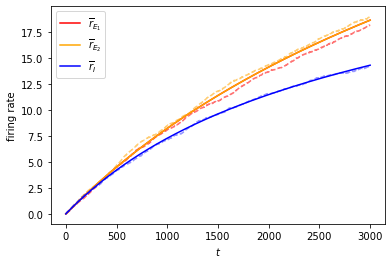

In [72]:
plt.plot(ts, R_n[0,:], color='red', linestyle='--', alpha=.55)
plt.plot(ts, R_ss[0,:], color='red', label=r'$\overline{r}_{E_1}$')

plt.plot(ts, R_n[1,:], color='orange', linestyle='--', alpha=.55)
plt.plot(ts, R_ss[1,:], color='orange', label=r'$\overline{r}_{E_2}$')

plt.plot(ts, R_n[2,:], color='b', linestyle='--', alpha=.4)
plt.plot(ts, R_ss[2,:], color='b', label=r'$\overline{r}_{I}$')

plt.xlabel(r'$t$')
plt.ylabel(f'firing rate')
plt.legend()
plt.show()

# Unstable $E$ units, symmetric connectivity

In [4]:
def cov_plot_symmetric_interactive(lowerW_EI, upperW_EI, lowerW_IE, upperW_IE, W_EE, W_II, k, tau, alpha):
    #range of J_EI
    W_EIs = np.linspace(lowerW_EI, upperW_EI, 100)
    W_IEs = np.linspace(lowerW_IE, upperW_IE, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # weights to fix
    W_E1E1 = W_EE
    W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha
    W_E2E1 = alpha

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_EIs)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_EI = W_EIs[i]
            W_IE = W_IEs[j]

            W = np.block([
                [W_E1E1, W_E1E2, W_EI],
                [W_E2E1, W_E2E2, W_EI],
                [W_IE, W_IE, W_II]
            ])
            
            # only shade plots if the rates are stable, otherwise hash
            if np.all(np.real(np.linalg.eig((1/tau)*(- np.eye(3) + sgn*W))[0]) < 0):
                # compute covariance matrix
                LW = L@(sgn*W)
                M = (1/tau)*(-Eye + LW)
                Minv = np.linalg.inv(M)
                Sigma = Minv @ D @ ((Minv@D).T)
                Cov_12 = Sigma[0,1]
                Covs_12[i,j] = Cov_12
            
            # if there is a non-neg. eigenvalue of (1/tau)*(I - W) has the corresponding point in the plot
            # np.pi is the value denoting the (W_IE, W_EI) pairs leading to instability, hash these
            else:
                Covs_12[i,j] = np.nan
    
    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=plt.get_cmap('PRGn')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    cmap = cm.get_cmap("PRGn").copy()
    cmap.set_bad(color='grey')
    
    # plot imshow colormap
    plt.imshow(np.flip(Covs_12, axis=0), cmap=cmap, extent=[np.min(W_IEs), np.max(W_IEs), np.min(W_EIs), np.max(W_EIs)], norm=divnorm)
    plt.colorbar()
    
    plt.title(r'Cov$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E}$')
    plt.ylabel(r'$W_{E \leftarrow I}$')
    

In [5]:
def corr_plot_symmetric_interactive(lowerW_EI, upperW_EI, lowerW_IE, upperW_IE, W_EE, W_II, k, tau, alpha):
    #range of J_EI
    W_EIs = np.linspace(lowerW_EI, upperW_EI, 100)
    W_IEs = np.linspace(lowerW_IE, upperW_IE, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # weights to fix
    W_E1E1 = W_EE
    W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha
    W_E2E1 = alpha

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_EIs)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_EI = W_EIs[i]
            W_IE = W_IEs[j]

            W = np.block([
                [W_E1E1, W_E1E2, W_EI],
                [W_E2E1, W_E2E2, W_EI],
                [W_IE, W_IE, W_II]
            ])
            
            # only shade plots if the rates are stable, otherwise hash
            if np.all(np.real(np.linalg.eig((1/tau)*(- np.eye(3) + sgn*W))[0]) < 0):
                # compute covariance matrix
                LW = L@(sgn*W)
                M = (1/tau)*(-Eye + LW)
                Minv = np.linalg.inv(M)
                Sigma = Minv@D@((Minv@D).T)
                Corr = correlation_from_covariance(Sigma)

                Corr_12 = Corr[0,1]
                Corrs_12[i,j] = Corr_12
            
            # if there is a non-neg. eigenvalue of (1/tau)*(I - W) has the corresponding point in the plot
            # np.pi is the value denoting the (W_IE, W_EI) pairs leading to instability, grey these out
            else:
                Corrs_12[i,j] = np.nan
    
    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=plt.get_cmap('seismic')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    cmap = cm.get_cmap("seismic").copy()
    cmap.set_bad(color='grey')
    
    # plot imshow colormap
    plt.imshow(np.flip(Corrs_12, axis=0), cmap=cmap, extent=[np.min(W_IEs), np.max(W_IEs), np.min(W_EIs), np.max(W_EIs)], norm=divnorm)
    plt.colorbar()
    
    plt.title(r'Corr$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E}$')
    plt.ylabel(r'$W_{E \leftarrow I}$')

In [6]:
interactive_plot = interactive(cov_plot_symmetric_interactive, lowerW_EI=fixed(0), upperW_EI=fixed(2), lowerW_IE=fixed(0), upperW_IE=fixed(2), W_EE=(0,2,0.05), W_II=(0,2,0.05), k=fixed(1), tau=fixed(15), alpha=(0.01,1,0.01))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='W_EE', max=2.0, step=0.05), FloatSlider(value=1.0, d…

In [7]:
interactive_plot = interactive(corr_plot_symmetric_interactive, lowerW_EI=fixed(0), upperW_EI=fixed(2), lowerW_IE=fixed(0), upperW_IE=fixed(2), W_EE=(0,2,0.05), W_II=(0,2,0.05), k=fixed(1), tau=fixed(15), alpha=(0.01,1,0.01))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='W_EE', max=2.0, step=0.05), FloatSlider(value=1.0, d…

## Cross-covariance functions 

In [6]:
def stationary_acovf(lags, M, sigma):
    nonpos_lags = lags[lags<=0]
    pos_lags = lags[lags>0]
    
    arr1 = [sigma @ expm((-M.T)*s) for s in nonpos_lags]
    arr2 = [expm(M*s) @ sigma for s in pos_lags]

    return np.append(arr1,arr2, axis=0)

In [7]:
def acfs_symmetric(lowerW_EI, upperW_EI, num_to_plot, W_E1E1, W_E2E2, W_II, W_IE, k, tau, alpha):
    W_EIs = np.linspace(lowerW_EI, upperW_EI, num_to_plot)

    # "cheat linearization"
    #k=1
    L = np.diag(np.repeat(k,3))

    # weights to fix
    #W_E1E1 = 1.1
    #W_E2E2 = 1.1
    #W_II = 0.8
    #W_IE = 0.8

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    #a = b = 0.2
    W_E1E2 = alpha
    W_E2E1 = alpha

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D

    lags = np.arange(-150,150)
    
    acfs = []
    for W_EI in W_EIs: 
        W = np.block([
                [W_E1E1, W_E1E2, W_EI],
                [W_E2E1, W_E2E2, W_EI],
                [W_IE, W_IE, W_II]
            ])

        # compute acf 
        M = (1/tau)*(-Eye + sgn*W) # L = I 
        sigma = solve_continuous_lyapunov(-M, D@(D.T))
        acf = stationary_acovf(lags, M, sigma)
        acfs.append([x[0,1] for x in acf])
        
    for i in range(len(acfs)):
        plt.plot(lags, acfs[i], label=f'Wei = {W_EIs[i]:.2f}', )
    plt.legend()
    plt.title(r'$C(\tau)$')
    plt.xlabel(r'$\tau$')

In [10]:
interactive_plot = interactive(acfs_symmetric, lowerW_EI=fixed(.7), upperW_EI=fixed(2), num_to_plot=fixed(6), W_E1E1=(0.05,2,0.05), W_E2E2=(0.05,2,0.05), W_II=(0.05,2,0.05), W_IE=(0.7,2,0.05), k=fixed(1), tau=fixed(15), alpha=(0.01,0.5,0.01))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='W_E1E1', max=2.0, min=0.05, step=0.05), FloatSlider(…

# Asymmetric connections

In [49]:
def cov_plot_asymmetric_case1(W_E1E1, W_E2E2, W_II, lowerW_E1I, upperW_E1I, lowerW_IE1, upperW_IE1, k, tau, alpha, delta):
    #range of J_EI
    W_E1Is = np.linspace(lowerW_E1I, upperW_E1I, 100)
    W_IE1s = np.linspace(lowerW_IE1, upperW_IE1, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # weights to fix
    #W_E1E1 = W_EE
    #W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha
    W_E2E1 = alpha

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_E1Is)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_E1I = W_E1Is[i]
            W_IE1 = W_IE1s[j]
            W_E2I = W_E1I + delta 
            W_IE2 = W_IE1 + delta

            W = np.block([
                [W_E1E1, W_E1E2, W_E1I],
                [W_E2E1, W_E2E2, W_E2I],
                [W_IE1, W_IE2, W_II]
            ])
            if np.all(np.real(np.linalg.eig((1/tau)*(- np.eye(3) + sgn*W))[0]) < 0):
                # compute covariance matrix
                LW = L@(sgn*W)
                M = (1/tau)*(-Eye + LW)
                Minv = np.linalg.inv(M)
                Sigma = Minv @ D @ ((Minv@D).T)
                Cov_12 = Sigma[0,1]
                Covs_12[i,j] = Cov_12
            else:
                Covs_12[i,j] = np.nan

    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=plt.get_cmap('PRGn')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    cmap = cm.get_cmap("PRGn").copy()
    cmap.set_bad(color='grey')
    
    # plot imshow colormap
    plt.imshow(np.flip(Covs_12, axis=0), cmap=cmap, extent=[np.min(W_IE1s), np.max(W_IE1s), np.min(W_E1Is), np.max(W_E1Is)], norm=divnorm)
    plt.colorbar()
    
    plt.title(r'Cov$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E}$')
    plt.ylabel(r'$W_{E \leftarrow I}$')

In [53]:
def corr_plot_asymmetric_case1(W_E1E1, W_E2E2, W_II, lowerW_E1I, upperW_E1I, lowerW_IE1, upperW_IE1, k, tau, alpha, delta):
    #range of J_EI
    W_E1Is = np.linspace(lowerW_E1I, upperW_E1I, 100)
    W_IE1s = np.linspace(lowerW_IE1, upperW_IE1, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # weights to fix
    #W_E1E1 = W_EE
    #W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha
    W_E2E1 = alpha

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_E1Is)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_E1I = W_E1Is[i]
            W_IE1 = W_IE1s[j]
            W_E2I = W_E1I + delta 
            W_IE2 = W_IE1 + delta

            W = np.block([
                [W_E1E1, W_E1E2, W_E1I],
                [W_E2E1, W_E2E2, W_E2I],
                [W_IE1, W_IE2, W_II]
            ])
            if np.all(np.real(np.linalg.eig((1/tau)*(- np.eye(3) + sgn*W))[0]) < 0):
                # compute covariance matrix
                LW = L@(sgn*W)
                M = (1/tau)*(-Eye + LW)
                Minv = np.linalg.inv(M)
                Sigma = Minv @ D @ ((Minv@D).T)
                Corr = correlation_from_covariance(Sigma)
                Corr_12 = Corr[0,1]
                Corrs_12[i,j] = Corr_12
            else:
                Corrs_12[i,j] = np.nan

    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=plt.get_cmap('seismic')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    cmap = cm.get_cmap("seismic").copy()
    cmap.set_bad(color='grey')
    
    # plot imshow colormap
    plt.imshow(np.flip(Corrs_12, axis=0), cmap=cmap, extent=[np.min(W_IE1s), np.max(W_IE1s), np.min(W_E1Is), np.max(W_E1Is)], norm=divnorm)
    plt.colorbar()
    
    plt.title(r'Corr$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E_1}$')
    plt.ylabel(r'$W_{E_1 \leftarrow I}$')

In [55]:
def corr_plot_asymmetric_case2(W_E1E1, W_E2E2, W_II, lowerW_E1I, upperW_E1I, lowerW_IE2, upperW_IE2, k, tau, alpha, delta):
    #range of J_EI
    W_E1Is = np.linspace(lowerW_E1I, upperW_E1I, 100)
    W_IE2s = np.linspace(lowerW_IE2, upperW_IE2, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # weights to fix
    #W_E1E1 = W_EE
    #W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha
    W_E2E1 = alpha

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_E1Is)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_E1I = W_E1Is[i]
            W_IE2 = W_IE2s[j]
            W_E2I = W_E1I + delta 
            W_IE1 = W_IE2 + delta

            W = np.block([
                [W_E1E1, W_E1E2, W_E1I],
                [W_E2E1, W_E2E2, W_E2I],
                [W_IE1, W_IE2, W_II]
            ])
            if np.all(np.real(np.linalg.eig((1/tau)*(- np.eye(3) + sgn*W))[0]) < 0):
                # compute covariance matrix
                LW = L@(sgn*W)
                M = (1/tau)*(-Eye + LW)
                Minv = np.linalg.inv(M)
                Sigma = Minv @ D @ ((Minv@D).T)
                Corr = correlation_from_covariance(Sigma)
                Corr_12 = Corr[0,1]
                Corrs_12[i,j] = Corr_12
            else:
                Corrs_12[i,j] = np.nan

    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=plt.get_cmap('seismic')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    cmap = cm.get_cmap("seismic").copy()
    cmap.set_bad(color='grey')
    
    # plot imshow colormap
    plt.imshow(np.flip(Corrs_12, axis=0), cmap=cmap, extent=[np.min(W_IE2s), np.max(W_IE2s), np.min(W_E1Is), np.max(W_E1Is)], norm=divnorm)
    plt.colorbar()
    
    plt.title(r'Corr$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E_2}$')
    plt.ylabel(r'$W_{E_1 \leftarrow I}$')

In [63]:
def corr_plot_asymmetric_case3(W_E1E1, W_E2E2, W_II, lowerW_EI, upperW_EI, lowerW_IE2, upperW_IE2, k, tau, alpha, delta):
    #range of J_EI
    W_EIs = np.linspace(lowerW_EI, upperW_EI, 100)
    W_IE2s = np.linspace(lowerW_IE2, upperW_IE2, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # weights to fix
    #W_E1E1 = W_EE
    #W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha
    W_E2E1 = alpha

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_EIs)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_E1I = W_EIs[i]
            W_E2I = W_EIs[i]
            W_IE2 = W_IE2s[j]
            W_IE1 = W_IE2 + delta

            W = np.block([
                [W_E1E1, W_E1E2, W_E1I],
                [W_E2E1, W_E2E2, W_E2I],
                [W_IE1, W_IE2, W_II]
            ])
            if np.all(np.real(np.linalg.eig((1/tau)*(- np.eye(3) + sgn*W))[0]) < 0):
                # compute covariance matrix
                LW = L@(sgn*W)
                M = (1/tau)*(-Eye + LW)
                Minv = np.linalg.inv(M)
                Sigma = Minv @ D @ ((Minv@D).T)
                Corr = correlation_from_covariance(Sigma)
                Corr_12 = Corr[0,1]
                Corrs_12[i,j] = Corr_12
            else:
                Corrs_12[i,j] = np.nan

    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=plt.get_cmap('seismic')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    cmap = cm.get_cmap("seismic").copy()
    cmap.set_bad(color='grey')
    
    # plot imshow colormap
    plt.imshow(np.flip(Corrs_12, axis=0), cmap=cmap, extent=[np.min(W_IE2s), np.max(W_IE2s), np.min(W_EIs), np.max(W_EIs)], norm=divnorm)
    plt.colorbar()
    
    plt.title(r'Corr$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E_2}$')
    plt.ylabel(r'$W_{E_1 \leftarrow I}$')

In [51]:
interactive_plot = interactive(cov_plot_asymmetric_case1, 
                               W_E1E1=(0.1,2,0.05), W_E2E2=(0.1,2,0.05), W_II=(0.1,2,0.05),
                               lowerW_E1I=fixed(0), upperW_E1I=fixed(2), lowerW_IE1=fixed(0), upperW_IE1=fixed(2), 
                               k=fixed(1), tau=fixed(15), 
                               alpha=(0,1,0.01),
                               delta=(0,3,0.01))
interactive_plot

interactive(children=(FloatSlider(value=1.05, description='W_E1E1', max=2.0, min=0.1, step=0.05), FloatSlider(…

In [54]:
interactive_plot = interactive(corr_plot_asymmetric_case1, 
                               W_E1E1=(0.1,2,0.05), W_E2E2=(0.1,2,0.05), W_II=(0.1,2,0.05),
                               lowerW_E1I=fixed(0), upperW_E1I=fixed(2), lowerW_IE1=fixed(0), upperW_IE1=fixed(2), 
                               k=fixed(1), tau=fixed(15), 
                               alpha=(0,1,0.01),
                               delta=(0,3,0.01))
interactive_plot

interactive(children=(FloatSlider(value=1.05, description='W_E1E1', max=2.0, min=0.1, step=0.05), FloatSlider(…

In [65]:
interactive_plot = interactive(corr_plot_asymmetric_case2, 
                               W_E1E1=(0.1,2,0.05), W_E2E2=(0.1,2,0.05), W_II=(0.1,2,0.05),
                               lowerW_E1I=fixed(0), upperW_E1I=fixed(2), lowerW_IE2=fixed(0), upperW_IE2=fixed(2), 
                               k=fixed(1), tau=fixed(15), 
                               alpha=(0,1,0.01),
                               delta=(0,3,0.01))
interactive_plot

interactive(children=(FloatSlider(value=1.05, description='W_E1E1', max=2.0, min=0.1, step=0.05), FloatSlider(…

In [66]:
interactive_plot = interactive(corr_plot_asymmetric_case3, 
                               W_E1E1=(0.1,2,0.05), W_E2E2=(0.1,2,0.05), W_II=(0.1,10,0.05),
                               lowerW_EI=fixed(0), upperW_EI=fixed(2), lowerW_IE2=fixed(0), upperW_IE2=fixed(2), 
                               k=fixed(1), tau=fixed(15), 
                               alpha=(0,1,0.01),
                               delta=(0,3,0.01))
interactive_plot

interactive(children=(FloatSlider(value=1.05, description='W_E1E1', max=2.0, min=0.1, step=0.05), FloatSlider(…

# Path contributions

In [8]:
def path_contributions(symmetric_connectivity, delta1, delta2, W_EE, W_II, W_IE, W_EI, sigE1, sigE2, sigI, tauE1, tauE2, tauI, alpha, nn):
    k=1
    N=1
    sgn = np.block([
        [np.ones((3*N,N)), np.ones((3*N,N)), -np.ones((3*N,N))]
    ])
    
    W_E1E2 = alpha*W_EE
    W_E2E1 = alpha*W_EE
    
    
    if symmetric_connectivity == 0: 
        W = np.block([
                        [W_EE, W_E1E2, W_EI],
                        [W_E2E1, W_EE, W_EI],
                        [W_IE, W_IE, W_II]
                    ])
        W = sgn*W
    
    elif symmetric_connectivity == 1: 
        W = np.block([
                        [W_EE, W_E1E2, W_EI],
                        [W_E2E1, W_EE, delta2+W_EI],
                        [delta1+W_IE, W_IE, W_II]
                    ])
        W = sgn*W
    
    L = np.diag(np.ones(3))
    LW = L@W
    Eye = np.eye(3*N)
    tau = np.diagflat(np.block([
            [np.full((N,1), tauE1)],
            [np.full((N,1), tauE2)],
            [np.full((N,1), tauI)]
        ]))
    c_n = np.diagflat(np.block([
            [np.full((N,1), np.sqrt(sigE1))],
            [np.full((N,1), np.sqrt(sigE2))],
            [np.full((N,1), np.sqrt(sigI))]
        ]))
    M = (np.linalg.inv(tau))@(-Eye + LW) 
    D = c_n@L
    D = np.sqrt(2)*(np.linalg.inv(tau))@D 
    Minv = np.linalg.inv(M)
    
    # if np.all(np.real(np.linalg.eig((1/tau)@(-Eye + W))[0]) < 0):
    #     print("system is stable")
    # else:
    #     print("system is un-stable")
    
    Sigma = Minv @ D @ (np.transpose(Minv@D))
    Corr = correlation_from_covariance(Sigma)
    Corr_E1E2 = Corr[0,1]
    Sigma_E1E2 = Sigma[0,1]
    
    WW = np.array([
        [((np.linalg.matrix_power(W,j))@(np.linalg.matrix_power(c_n,2))@np.transpose(np.linalg.matrix_power(W,k)))[0,1] for j in range(nn+1)] for k in range(nn+1)
    ])
    CovPaths_by_order = [np.sum(np.diagonal(WW[::-1], offs)) for offs in range(-WW.shape[0]+1, WW.shape[1])]
    
    approx_Sigma = 2*np.sum([(np.linalg.matrix_power(W,j))@(np.linalg.matrix_power(c_n,2))@(np.transpose(np.linalg.matrix_power(W,k))) for j in range(nn+1) for k in range(nn+1)],0)
    approx_Corr = correlation_from_covariance(approx_Sigma)
    
    
    figure(figsize=(12, 6), dpi=80)
    plt.bar(0, Sigma_E1E2, width=.1, label="total covariance")
    plt.bar(0, approx_Sigma[0,1], width=.1, label=f"$N =$ {nn} approximate covariance")
    total=np.zeros((3,3))
    for m in range(1,len(CovPaths_by_order)): 
        plt.bar(.2*m, 2*CovPaths_by_order[m], width=.1, label=f"Order {m} paths")
    #plt.bar(0.2+.2*(m+1), 2*np.sum(CovPaths_by_order), width=.1, label="summed paths")
    print(2*np.sum(CovPaths_by_order))
    
    plt.axhline(y=0, color="r", linestyle="--")
    plt.legend(bbox_to_anchor=(1.1,1), loc="upper left", fontsize=12)
    print(f"\nmax absolute eigenvalue: {np.max(np.absolute(np.linalg.eigvals(W))):4f}\n")
    print(f"total covariance: {Sigma_E1E2:4f}")
    print(f"covariance approximated to N = {nn} terms: {approx_Sigma[0,1]:4f}")
    



In [9]:
interactive_plot = interactive(path_contributions, 
                               symmetric_connectivity=(0,1,1),
                               delta1=(0,1,.01),
                               delta2=(0,1,.01),
                               W_EE=(.9,1.5,.05),
                               W_II=(.9,1.5,.05),
                               W_IE=(0,2,.01),
                               W_EI=(0,2,.01),
                               sigE1=(0,2,.01),
                               sigE2=(0,2,.01),
                               sigI=(0,2,.01),
                               tauE1=fixed(15),
                               tauE2=fixed(15),
                               tauI=fixed(15),
                               alpha=(0,1,.01),
                               nn=(1,21,1)
                              )
interactive_plot

interactive(children=(IntSlider(value=0, description='symmetric_connectivity', max=1), FloatSlider(value=0.0, …

# Eigenvalues 

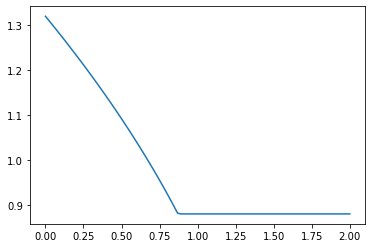

In [12]:
W_II = W_EE = 1.1
W_EI = 0.5
Wie = np.linspace(0,2,100)
alpha = 0.2
W_E1E2 = alpha*W_EE
W_E2E1 = alpha*W_EE
y = []
for W_IE in Wie:
    W = np.block([
                [W_EE, W_E1E2, -W_EI],
                [W_E2E1, W_EE, -W_EI],
                [W_IE, W_IE, -W_II]
            ])
    y.append(np.max(np.absolute(np.linalg.eigvals(W))))
    
    
plt.plot(Wie, y)
plt.show()

In [22]:
def abs_max_eigenvals(alpha, W_EE, W_II, W_EI, W_IEmin, W_IEmax):
    Wie = np.linspace(W_IEmin, W_IEmax, 100)
    W_E1E2 = alpha*W_EE
    W_E2E1 = alpha*W_EE
    y = []
    for W_IE in Wie:
        W = np.block([
                    [W_EE, W_E1E2, -W_EI],
                    [W_E2E1, W_EE, -W_EI],
                    [W_IE, W_IE, -W_II]
                ])
        y.append(np.max(np.absolute(np.linalg.eigvals(W))))
    plt.plot(Wie, y)
    plt.axhline(y=1, color="r", linestyle="--")
    plt.ylim(0,2)
    plt.xlabel()
    plt.ylabel()
    plt.show()

In [23]:
interactive_plot = interactive(abs_max_eigenvals, 
                               alpha=(0,1,.05),
                               W_EE=(0,2,.05),
                               W_II=(0,2,.05),
                               W_EI=(0,2,.05),
                               W_IEmin=fixed(0),
                               W_IEmax=fixed(2)
                              )
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), FloatSlider(value=1.0, …

# Rates/inputs 

In [21]:
def inputs_given_rates(rbarE1, rbarE2, rbarI, lowerW_EI, upperW_EI, lowerW_IE, upperW_IE, W_EE, W_II, sigE1, sigE2, sigI, tauE1, tauE2, tauI, alpha):
    N=3
    #range of J_EI
    W_EIs = np.linspace(lowerW_EI, upperW_EI, 100)
    W_IEs = np.linspace(lowerW_IE, upperW_IE, 100)

    L = np.eye(3,3)

    # weights to fix
    W_E1E1 = W_EE
    W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1
    
    tau = np.diagflat(np.block([
            [np.full((N,1), tauE1)],
            [np.full((N,1), tauE2)],
            [np.full((N,1), tauI)]
        ]))
    c_n = np.diagflat(np.block([
            [np.full((N,1), np.sqrt(sigE1))],
            [np.full((N,1), np.sqrt(sigE2))],
            [np.full((N,1), np.sqrt(sigI))]
        ]))
    rbar = np.array([[rbarE1],[rbarE2],[rbarI]])
    
    
    # connection E1 <-> E2 
    W_E1E2 = alpha*W_E2E2
    W_E2E1 = alpha*W_E1E1

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)

    K = len(W_EIs)

    
    muE1 = np.zeros((K,K))
    muE2 = np.zeros((K,K))
    muI = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_EI = W_EIs[i]
            W_IE = W_IEs[j]

            W = np.block([
                [W_E1E1, W_E1E2, W_EI],
                [W_E2E1, W_E2E2, W_EI],
                [W_IE, W_IE, W_II]
            ])
            W = sgn*W
            
            mu = (Eye - W)@rbar
            
            muE1[i,j] = mu[0,0]
            muE2[i,j] = mu[1,0]
            muI[i,j] = mu[2,0]
            
    display(Latex(f'$r =  ({rbarE1},{rbarE2},{rbarI})$'))
            
            
    divnorm1=colors.TwoSlopeNorm(vcenter=0)
    divnorm2=colors.TwoSlopeNorm(vcenter=0)
    divnorm3=colors.TwoSlopeNorm(vcenter=0)
    
    cmap=cm.get_cmap('PRGn')
    
    im1=cm.ScalarMappable(norm=divnorm1, cmap=cmap)
    im2=cm.ScalarMappable(norm=divnorm2, cmap=cmap)
    im3=cm.ScalarMappable(norm=divnorm3, cmap=cmap)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
    
    muE1_plot = ax1.imshow(np.flip(muE1, axis=0), cmap=cmap, norm=divnorm1, extent=[np.min(W_IEs), np.max(W_IEs), np.min(W_EIs), np.max(W_EIs)])
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.08)
    plt.colorbar(muE1_plot, cax=cax1)
    ax1.set_title(r'$\mu_{E_1}$', fontsize=30)
    ax1.set_xlabel(r'$W_{I \leftarrow E}$', fontsize=20)
    ax1.set_ylabel(r'$W_{E \leftarrow I}$', fontsize=20)
    
    
    muE2_plot = ax2.imshow(np.flip(muE2, axis=0), cmap=cmap, norm=divnorm2, extent=[np.min(W_IEs), np.max(W_IEs), np.min(W_EIs), np.max(W_EIs)])
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.08)
    plt.colorbar(muE2_plot, cax=cax2)
    ax2.set_title(r'$\mu_{E_2}$', fontsize=30)
    ax2.set_xlabel(r'$W_{I \leftarrow E}$', fontsize=20)
    ax2.set_ylabel(r'$W_{E \leftarrow I}$', fontsize=20)

    
    muI_plot = ax3.imshow(np.flip(muI, axis=0), cmap=cmap, norm=divnorm3, extent=[np.min(W_IEs), np.max(W_IEs), np.min(W_EIs), np.max(W_EIs)])
    divider = make_axes_locatable(ax3)
    cax3 = divider.append_axes("right", size="5%", pad=0.08)
    plt.colorbar(muI_plot, cax=cax3)
    ax3.set_title(r'$\mu_{I}$', fontsize=30)
    ax3.set_xlabel(r'$W_{I \leftarrow E}$', fontsize=20)
    ax3.set_ylabel(r'$W_{E \leftarrow I}$', fontsize=20)
    
    
    
    plt.tight_layout()
    plt.show()

In [22]:
interactive(inputs_given_rates, 
                          rbarE1=fixed(10),
                          rbarE2=fixed(10),
                          rbarI=fixed(15),
                          lowerW_EI=fixed(0),
                          upperW_EI=fixed(1), 
                          lowerW_IE=fixed(0), 
                          upperW_IE=fixed(1),
                          W_EE=(.8,1.3,.05),
                          W_II=(.8,1.3,.05),
                          sigE1=fixed(1),
                          sigE2=fixed(1),
                          sigI=fixed(1),
                          tauE1=fixed(15),
                          tauE2=fixed(15),
                          tauI=fixed(15),
                          alpha=(0,1,.05)
                              )

interactive(children=(FloatSlider(value=1.05, description='W_EE', max=1.3, min=0.8, step=0.05), FloatSlider(va…